In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [40]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 327


In [41]:
scaler = MinMaxScaler().fit(train_df[["days_since_previous_release", "days_until_next_holiday"]])
train_df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    train_df[["days_since_previous_release", "days_until_next_holiday"]])
test_df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    test_df[["days_since_previous_release", "days_until_next_holiday"]])

In [43]:
scaler = MinMaxScaler().fit(df[["days_since_previous_release", "days_until_next_holiday"]])
df[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    df[["days_since_previous_release", "days_until_next_holiday"]])
next_two_weeks[["days_since_previous_release", "days_until_next_holiday"]] = scaler.transform(
    next_two_weeks[["days_since_previous_release", "days_until_next_holiday"]])

## Model-Building and Evaluation

In [44]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [45]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [46]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.04,0.03,0.99,1.10,0.0,0.0,3031.84,2847.09,1.0
WD_Tuesday,0.08,0.01,0.06,0.11,0.0,0.0,1827.75,2875.04,1.0
WD_Wednesday,0.08,0.01,0.05,0.10,0.0,0.0,1970.04,3003.83,1.0
WD_Monday,0.06,0.01,0.04,0.09,0.0,0.0,1756.05,2453.23,1.0
WD_Thursday,0.05,0.01,0.02,0.07,0.0,0.0,2048.69,2909.28,1.0
days_until_next_holiday,0.04,0.02,0.01,0.07,0.0,0.0,3771.67,2917.21,1.0
WD_Sunday,0.01,0.01,-0.01,0.04,0.0,0.0,1913.71,2483.37,1.0
WD_Saturday,-0.00,0.01,-0.03,0.02,0.0,0.0,1850.64,2445.49,1.0
previous_release_preorder,-0.03,0.03,-0.09,0.02,0.0,0.0,3415.47,2984.07,1.0


In [47]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.27,0.01,0.25,0.30,0.0,0.0,1418.27,2192.42,1.0
error,0.16,0.00,0.16,0.17,0.0,0.0,4110.44,2776.92,1.0


### Out-of-Sample Evaluation

In [48]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [49]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [50]:
mape(test_df["prob_of_release"], y_pred)

0.24052119438411537

In [51]:
wape(test_df["prob_of_release"], y_pred)

0.22675872216223902

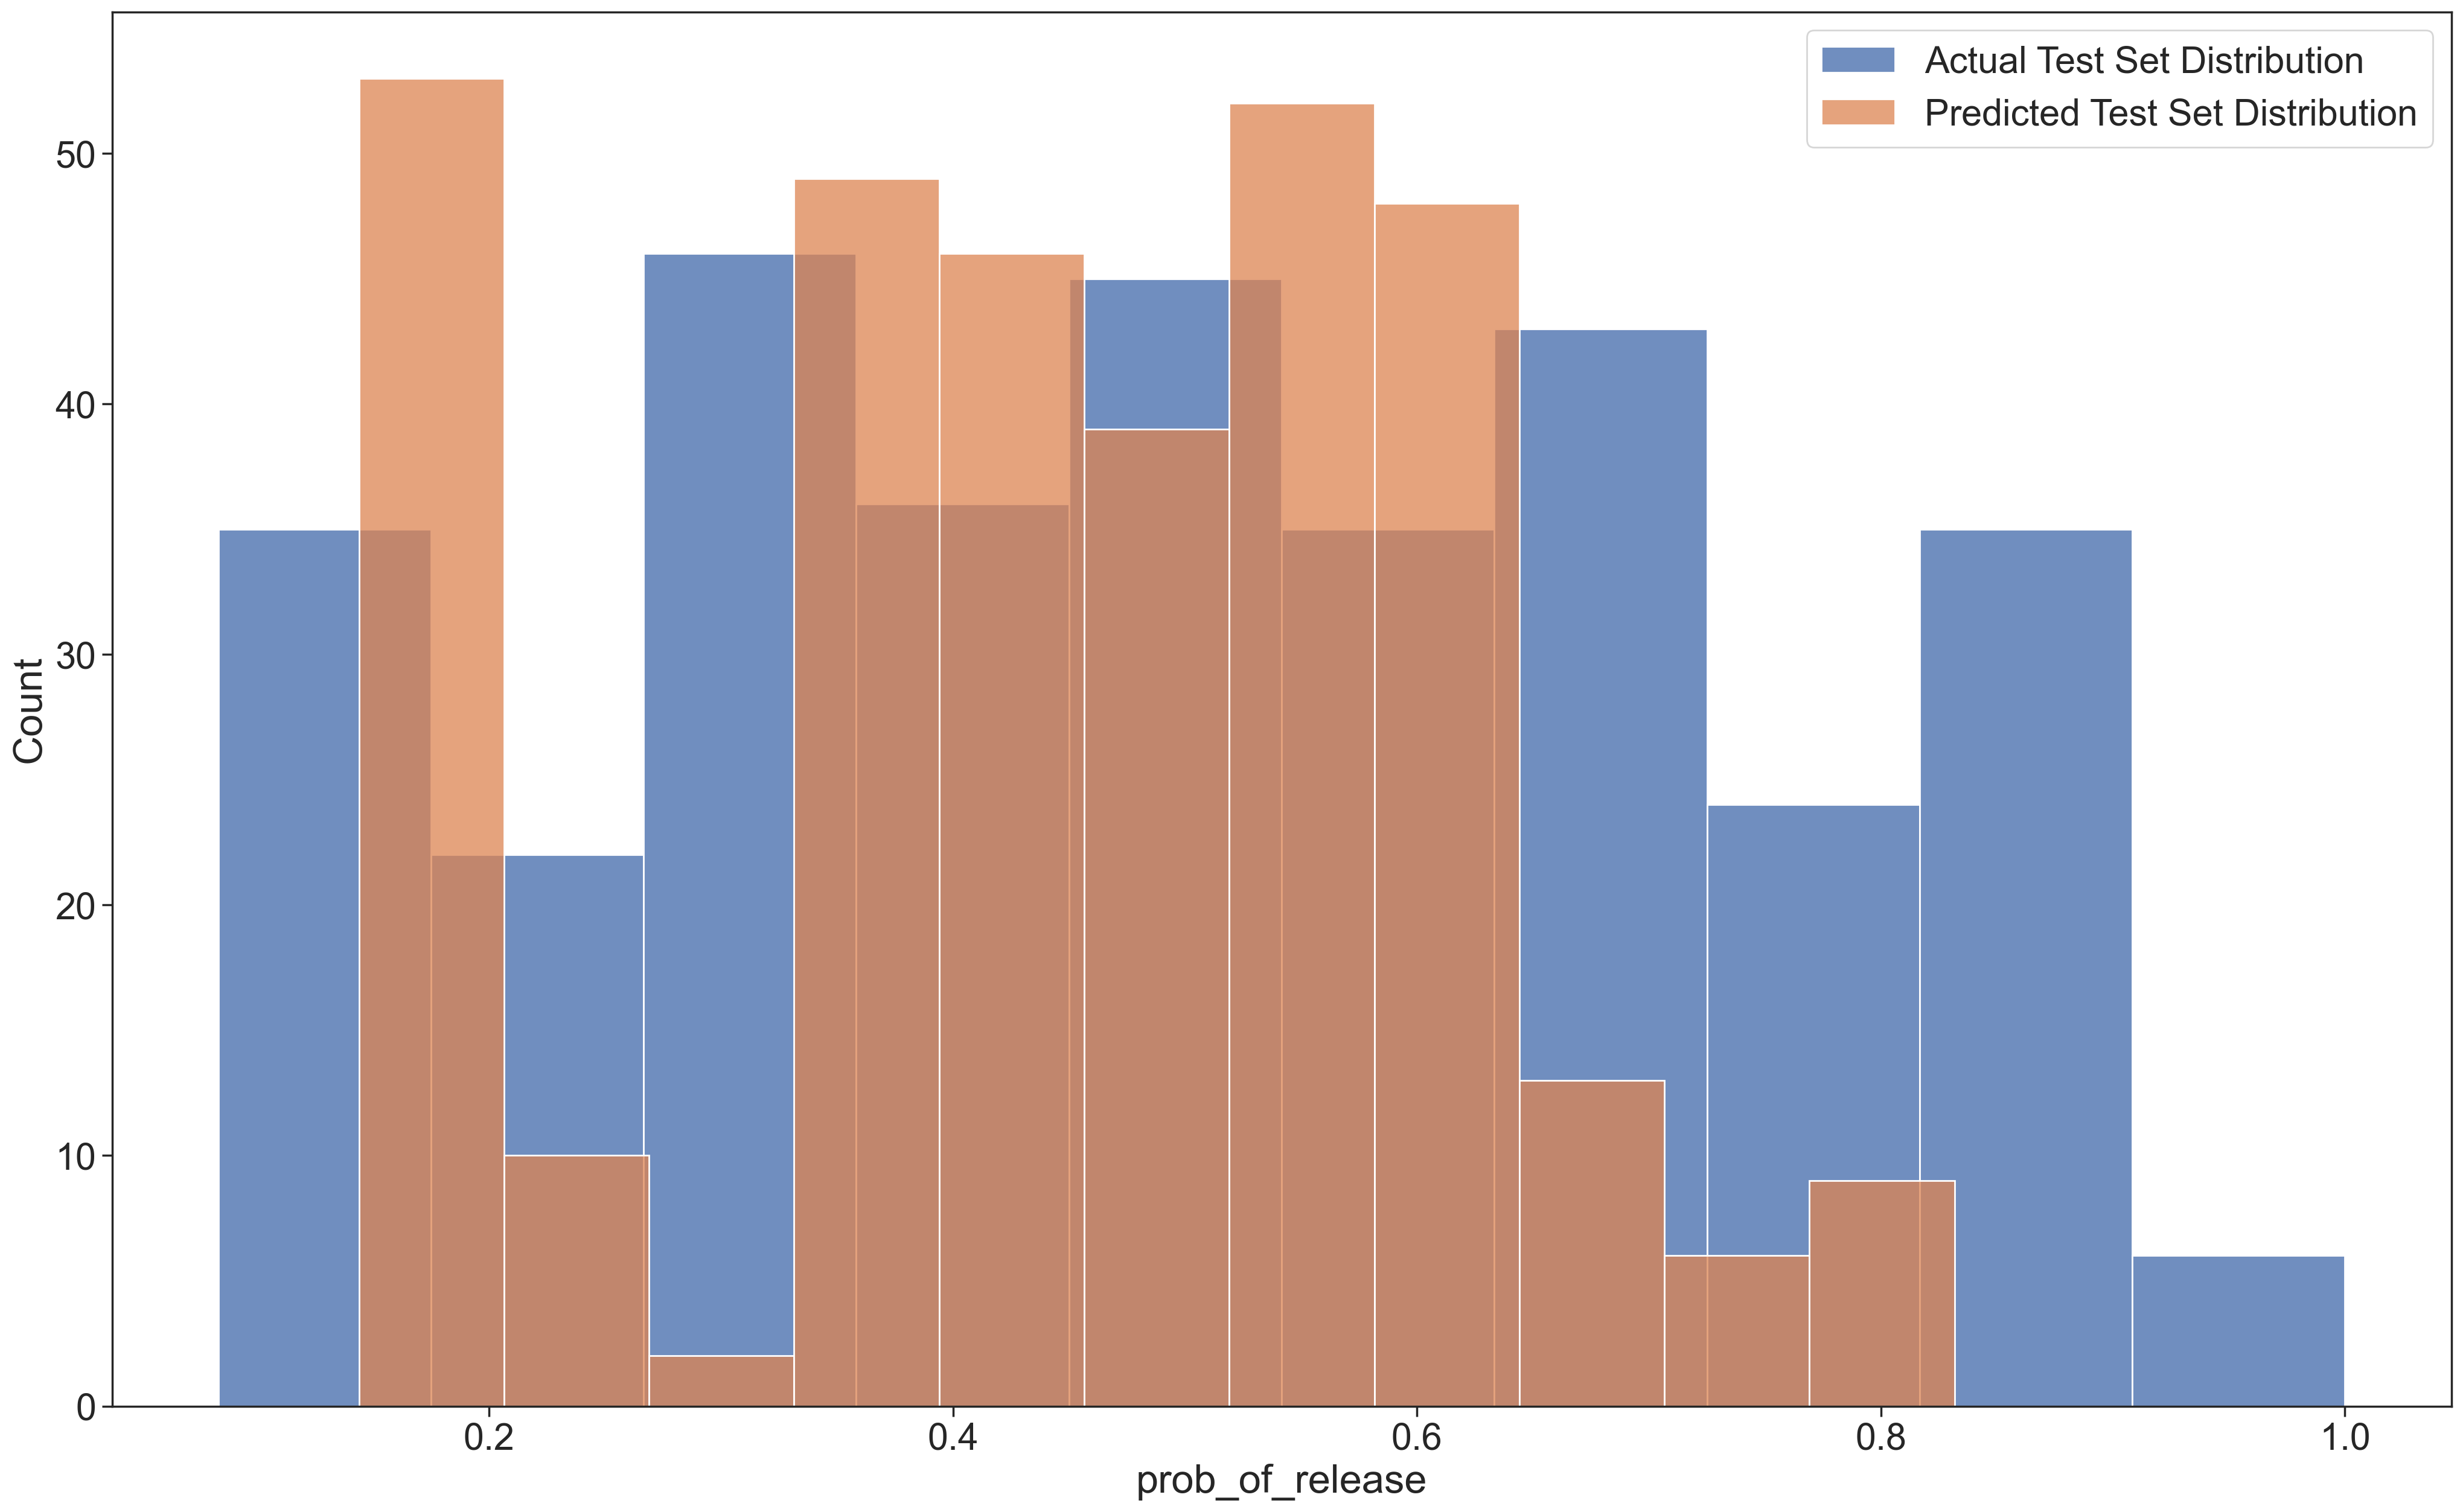

In [52]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [53]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [54]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [55]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.03,0.03,0.98,1.08,0.0,0.0,2731.03,2743.03,1.0
WD_Tuesday,0.09,0.01,0.07,0.12,0.0,0.0,2054.83,2671.34,1.0
WD_Wednesday,0.09,0.01,0.07,0.11,0.0,0.0,2300.49,2749.99,1.0
WD_Monday,0.07,0.01,0.05,0.10,0.0,0.0,2280.58,2429.83,1.0
WD_Thursday,0.06,0.01,0.04,0.08,0.0,0.0,2249.84,2758.04,1.0
days_until_next_holiday,0.04,0.01,0.01,0.07,0.0,0.0,3303.75,2716.34,1.0
WD_Sunday,0.02,0.01,-0.01,0.04,0.0,0.0,2136.93,2319.24,1.0
WD_Saturday,-0.00,0.01,-0.02,0.02,0.0,0.0,1985.91,2399.85,1.0
previous_release_preorder,-0.02,0.02,-0.07,0.03,0.0,0.0,3272.82,2555.89,1.0


In [56]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.28,0.01,0.25,0.30,0.0,0.0,1690.35,2192.80,1.0
error,0.16,0.00,0.16,0.17,0.0,0.0,3770.30,3256.15,1.0


In [57]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [58]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [59]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [60]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2024-11-25,0.1120,0.4421,0.7432
1,2024-11-26,0.1686,0.5124,0.8150
2,2024-11-27,0.2569,0.5636,0.8965
3,2024-11-28,0.2623,0.5794,0.9022
4,2024-11-29,0.2739,0.5955,0.9027
5,2024-11-30,0.3534,0.6392,0.9512
6,2024-12-01,0.4342,0.7025,0.9865
7,2024-12-02,0.5396,0.7832,0.9999
8,2024-12-03,0.6128,0.8280,0.9997
9,2024-12-04,0.6434,0.8515,0.9999


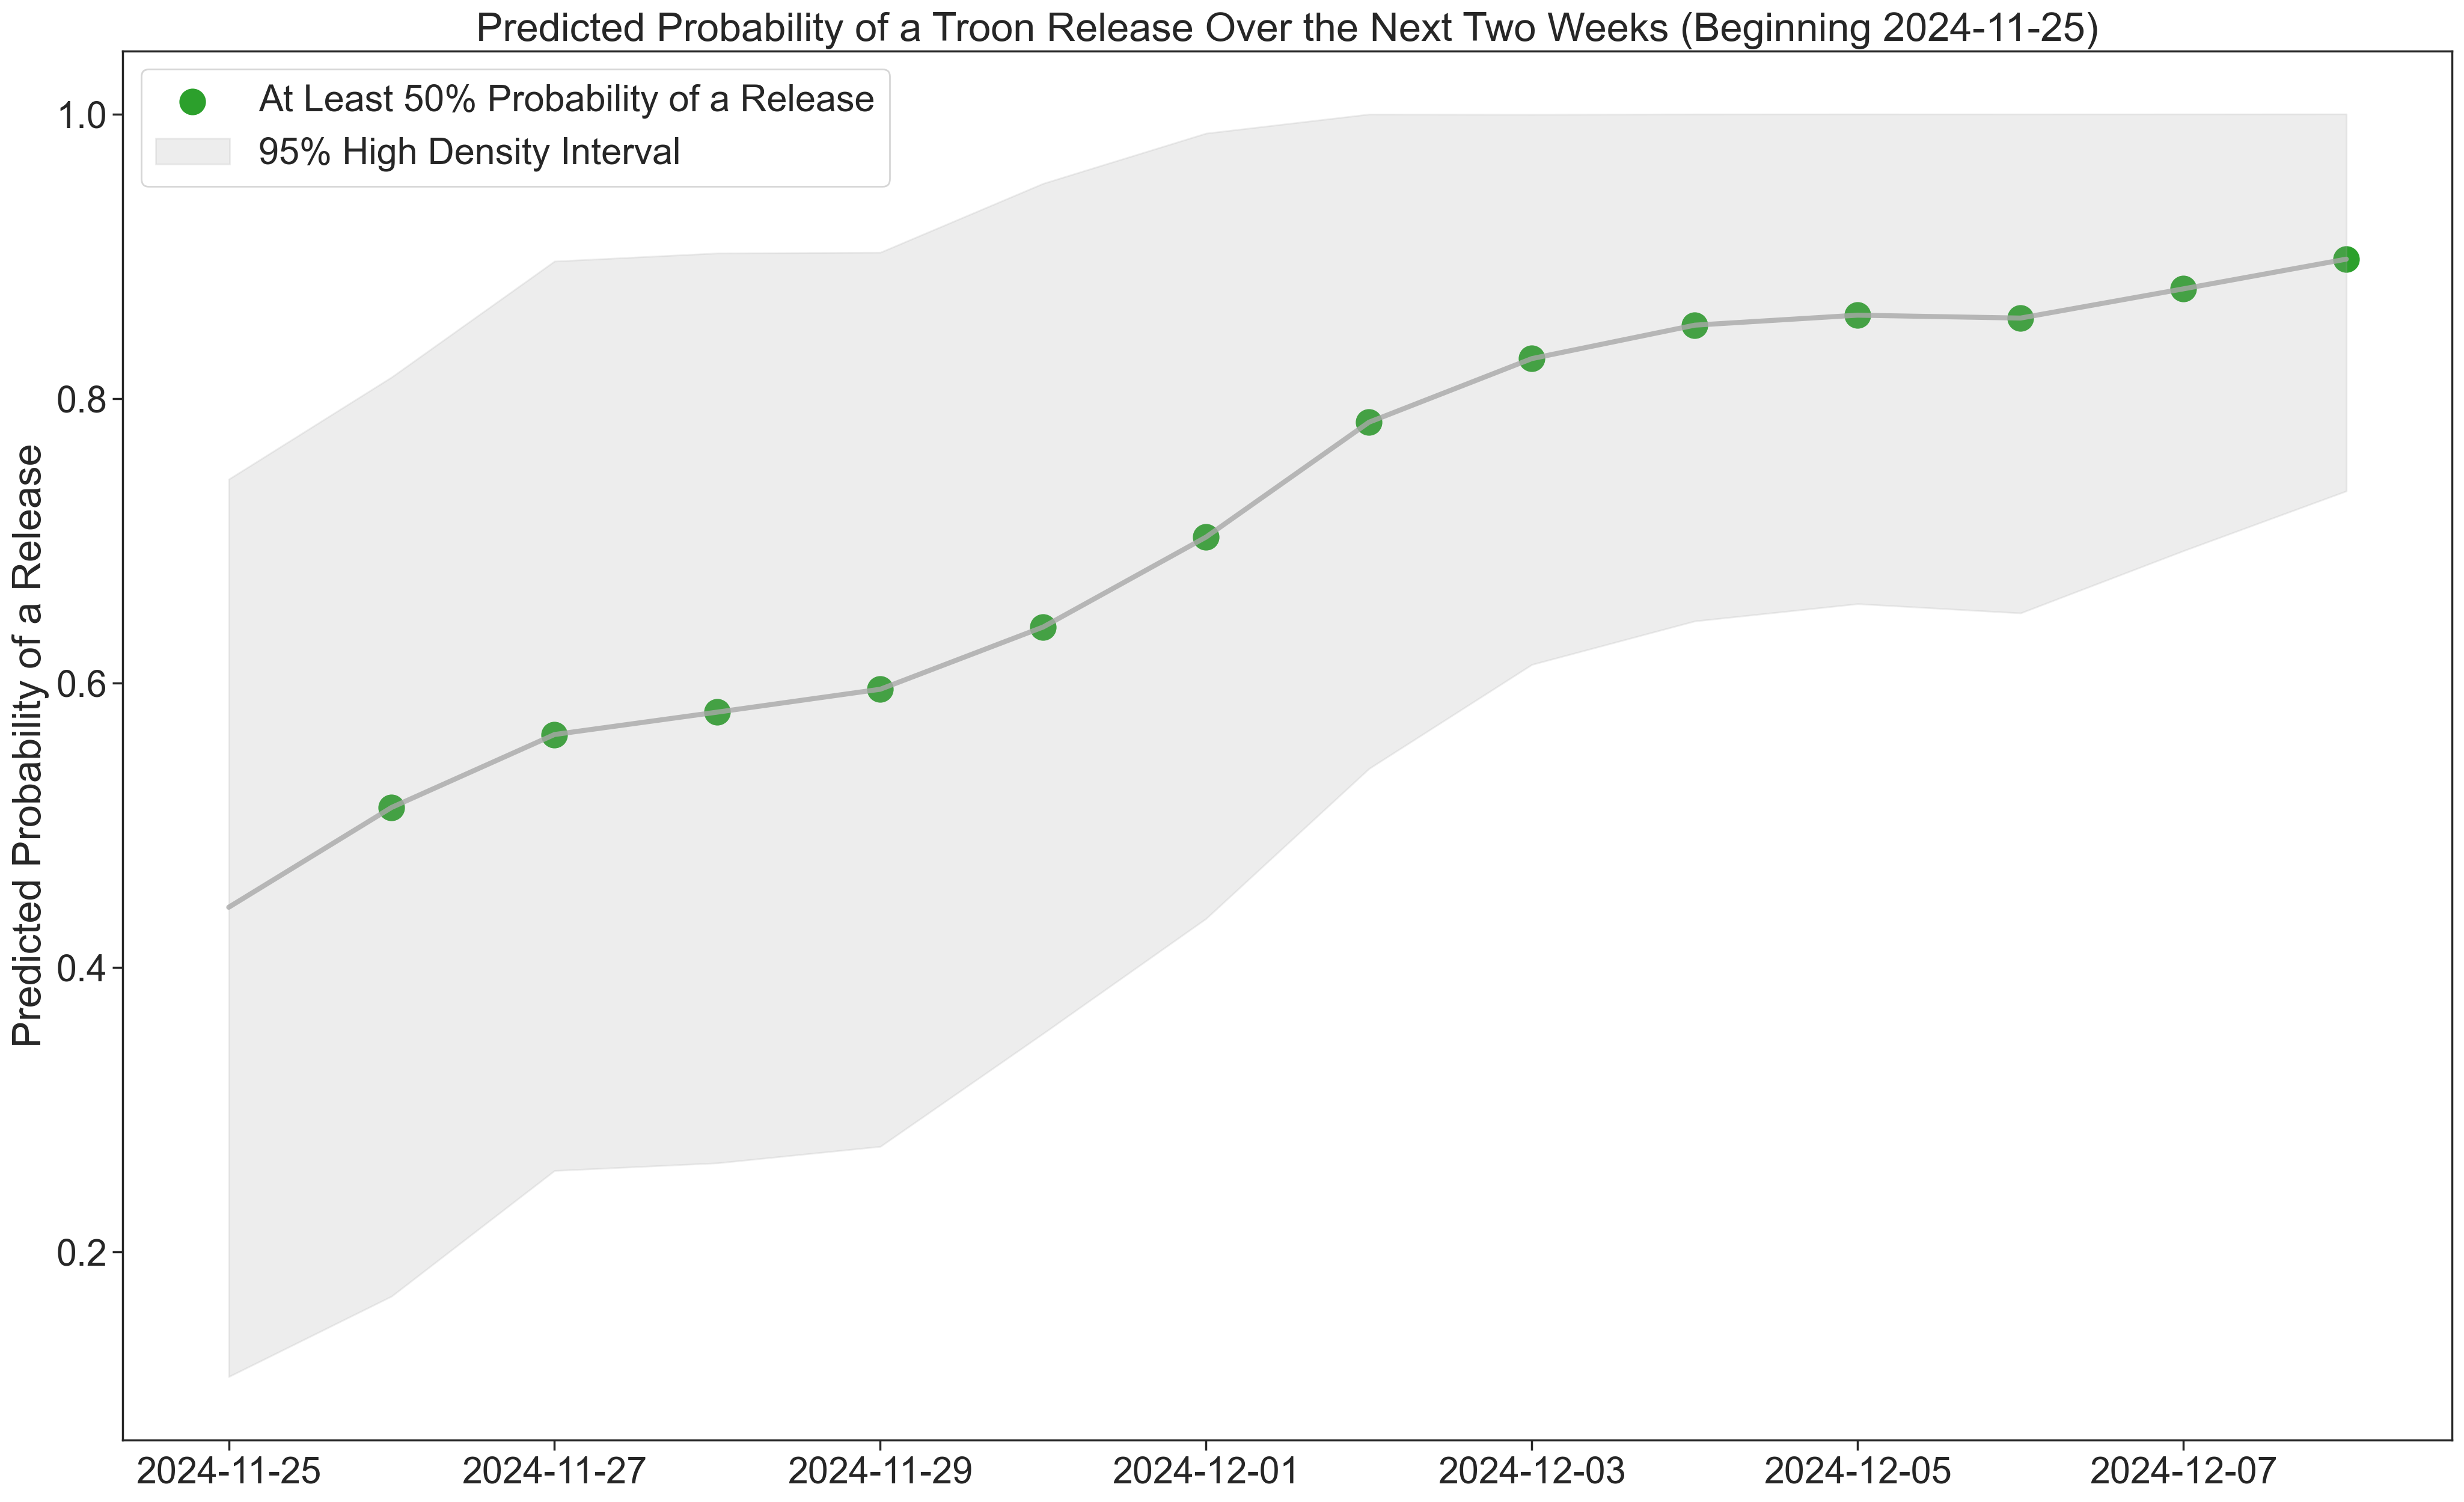

In [61]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()